In [2]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import utils
# (Keep your other imports, e.g., for transforms, if needed)

class type_dataset(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=False, crop_augmentation=False):
        self.data = []
        self.transform = transform
        self.augmentation = augmentation
        self.crop_augmentation = crop_augmentation

        folder_list = ['blank', 'cells']
        for folder_label, folder in enumerate(folder_list):
            folder_dir = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_dir):
                image_path = os.path.join(folder_dir, fname)
                image = Image.open(image_path)
                image = np.array(image)
                self.data.append((image, folder_label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the primary image and label
        image, label = self.data[idx]
        # Convert to tensor and repeat for 3 channels if necessary
        image_tensor = torch.from_numpy(image).repeat(3, 1, 1).float()
        # Apply any prebuilt transform
        flips = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5)
                            ])
        if self.crop_augmentation:
            crop_size = random.randint(160, 320)
            top = random.randint(0, 320 - crop_size)
            left = random.randint(0, 320 - crop_size)
            image_tensor = image_tensor[:, top:top+crop_size, left:left+crop_size]

        if self.transform:
            image_tensor = self.transform(image_tensor)
        
        if self.augmentation:
            # ---- CutMix Augmentation Start ----
            image_tensor = flips(image_tensor)
            
            # Sample a random second image (optionally ensure it's different from idx)
            rand_idx = random.randint(0, len(self.data) - 1)
            image2, label2 = self.data[rand_idx]
            image_tensor2 = torch.from_numpy(image2).repeat(3, 1, 1).float()
            if self.crop_augmentation:
                image_tensor2 = image_tensor2[:, top:top+crop_size, left:left+crop_size]
            
            if self.transform:
                image_tensor2 = self.transform(image_tensor2)
            image_tensor2 = flips(image_tensor2)
            
            # Sample lambda from a Beta distribution (here using alpha=1.0 for both sides)
            lam = np.random.beta(1.0, 1.0)
            # Get image dimensions (assuming images are of equal size)
            _, H, W = image_tensor.size()
            # Compute the size of the patch to cut and paste
            r = np.sqrt(1 - lam)
            cut_w = int(W * r)
            cut_h = int(H * r)
            
            # Choose a random center point for the patch
            cx = np.random.randint(W)
            cy = np.random.randint(H)
            
            # Calculate the bounding box coordinates and clip to image size
            x1 = np.clip(cx - cut_w // 2, 0, W)
            y1 = np.clip(cy - cut_h // 2, 0, H)
            x2 = np.clip(cx + cut_w // 2, 0, W)
            y2 = np.clip(cy + cut_h // 2, 0, H)
            
            # Replace the region in image_tensor with the corresponding patch from image_tensor2
            image_tensor[:, y1:y2, x1:x2] = image_tensor2[:, y1:y2, x1:x2]
            
            # Adjust lambda to exactly match the pixel ratio of the mixed region
            lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
            # Return a tuple for the label: (label_a, label_b, lam)
            label = (label, label2, lam)
            # ---- CutMix Augmentation End ----
            
        return image_tensor, label

In [3]:
from utils.AugmentedDatasetWrapper import AugmentedDatasetWrapper
from torch.utils.data import DataLoader
from torchvision import models

train_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/test"
val_dir = "C:/rkka_Projects/cell_death_v2/Data/model_training/train"

transform = models.ResNet18_Weights.IMAGENET1K_V1.transforms()
train_dataset = type_dataset(train_dir, transform=transform, augmentation=True, crop_augmentation=True)
val_dataset = type_dataset(val_dir, transform=transform, augmentation=False, crop_augmentation=True)
augmented_train_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=3)
augmented_val_dataset = AugmentedDatasetWrapper(dataset=train_dataset, num_repeats=1)

train_loader = DataLoader(dataset=augmented_train_dataset, shuffle=True, batch_size=64)
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=64)

In [4]:
import utils
from torchvision import models

model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)

for name, params in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        params.requires_grad = True
    else:
        params.requires_grad = False
        
utils.print_trainable_parameters(model)

Total Parameters: 11,177,538
Trainable Parameters: 8,394,754


c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Increase the weight for classes 3 and 4; adjust values as needed
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

model = model.cuda()

In [6]:
import torch
from tqdm import tqdm
import datetime

for epoch in tqdm(range(30)):
    # train
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    
    for images, labels in train_loader:
        images = images.cuda()
        
        # Move each component of labels to the GPU if using CutMix
        if isinstance(labels, (list, tuple)):
            label_a, label_b, lam = labels
            label_a = label_a.cuda()
            label_b = label_b.cuda()
            lam     = lam.cuda()
        else:
            labels = labels.cuda()
        
        outputs = model(images)
        
        if isinstance(labels, (list, tuple)):
            # Compute per-sample losses by setting reduction='none'
            loss_a = torch.nn.functional.cross_entropy(outputs, label_a, reduction='none')
            loss_b = torch.nn.functional.cross_entropy(outputs, label_b, reduction='none')
            # Combine losses per sample and then average to get a scalar loss
            loss = (lam * loss_a + (1 - lam) * loss_b).mean()
        else:
            loss = criterion(outputs, labels)  # This remains as is if no CutMix is used
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    #validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.cuda(), val_labels.cuda()
                
            outputs = model(val_images)
            loss = criterion(outputs, val_labels)
            val_loss += loss
                
            _, preds = torch.max(outputs, 1)
            val_correct += (preds==val_labels).sum().item()
            val_total += len(val_labels)
    
    # torch.save(model.state_dict(), f'trained_models/training_epoch_{epoch+6}_type_5_classes_{train_loss:.6f}_{val_correct/val_total:.4f}.pth')
    
    print(f"Epoch : {epoch}")
    print(f"train loss : {train_loss:.6f}")
    print(f"val loss : {val_loss:.6f} || val_acc : {val_correct/val_total:.4f}")
        

  3%|▎         | 1/30 [00:00<00:26,  1.08it/s]

Epoch : 0
train loss : 4.484518
val loss : 3.245991 || val_acc : 0.9476


  7%|▋         | 2/30 [00:01<00:21,  1.29it/s]

Epoch : 1
train loss : 2.895083
val loss : 24.570429 || val_acc : 0.5112


 10%|█         | 3/30 [00:02<00:19,  1.39it/s]

Epoch : 2
train loss : 2.801448
val loss : 6.719546 || val_acc : 0.6733


 13%|█▎        | 4/30 [00:02<00:17,  1.47it/s]

Epoch : 3
train loss : 2.277597
val loss : 1.550814 || val_acc : 0.9501


 17%|█▋        | 5/30 [00:03<00:16,  1.53it/s]

Epoch : 4
train loss : 2.259802
val loss : 1.227573 || val_acc : 0.9476


 20%|██        | 6/30 [00:04<00:15,  1.54it/s]

Epoch : 5
train loss : 2.190506
val loss : 1.626256 || val_acc : 0.9377


 23%|██▎       | 7/30 [00:04<00:14,  1.57it/s]

Epoch : 6
train loss : 2.107603
val loss : 1.290967 || val_acc : 0.9551


 27%|██▋       | 8/30 [00:05<00:14,  1.54it/s]

Epoch : 7
train loss : 1.988013
val loss : 1.049942 || val_acc : 0.9476


 30%|███       | 9/30 [00:06<00:13,  1.52it/s]

Epoch : 8
train loss : 2.232493
val loss : 1.009494 || val_acc : 0.9501


 33%|███▎      | 10/30 [00:06<00:13,  1.48it/s]

Epoch : 9
train loss : 2.053613
val loss : 0.965000 || val_acc : 0.9526


 37%|███▋      | 11/30 [00:07<00:13,  1.44it/s]

Epoch : 10
train loss : 2.267621
val loss : 1.142665 || val_acc : 0.9501


 40%|████      | 12/30 [00:08<00:12,  1.41it/s]

Epoch : 11
train loss : 2.414118
val loss : 1.136136 || val_acc : 0.9526


 43%|████▎     | 13/30 [00:09<00:12,  1.38it/s]

Epoch : 12
train loss : 2.113222
val loss : 1.170637 || val_acc : 0.9476


 47%|████▋     | 14/30 [00:09<00:11,  1.39it/s]

Epoch : 13
train loss : 2.088938
val loss : 1.582094 || val_acc : 0.9476


 50%|█████     | 15/30 [00:10<00:10,  1.37it/s]

Epoch : 14
train loss : 2.284487
val loss : 1.204054 || val_acc : 0.9451


 53%|█████▎    | 16/30 [00:11<00:10,  1.36it/s]

Epoch : 15
train loss : 1.947734
val loss : 1.393476 || val_acc : 0.9277


 57%|█████▋    | 17/30 [00:11<00:09,  1.36it/s]

Epoch : 16
train loss : 2.107585
val loss : 0.988153 || val_acc : 0.9401


 60%|██████    | 18/30 [00:12<00:08,  1.35it/s]

Epoch : 17
train loss : 2.122751
val loss : 0.977113 || val_acc : 0.9501


 63%|██████▎   | 19/30 [00:13<00:08,  1.34it/s]

Epoch : 18
train loss : 1.981727
val loss : 1.286323 || val_acc : 0.9501


 67%|██████▋   | 20/30 [00:14<00:07,  1.34it/s]

Epoch : 19
train loss : 1.943427
val loss : 1.308306 || val_acc : 0.9426


 70%|███████   | 21/30 [00:14<00:06,  1.35it/s]

Epoch : 20
train loss : 1.901381
val loss : 0.927724 || val_acc : 0.9476


 73%|███████▎  | 22/30 [00:15<00:05,  1.36it/s]

Epoch : 21
train loss : 2.106754
val loss : 1.157847 || val_acc : 0.9526


 77%|███████▋  | 23/30 [00:16<00:05,  1.34it/s]

Epoch : 22
train loss : 2.083560
val loss : 1.364409 || val_acc : 0.9377


 80%|████████  | 24/30 [00:17<00:04,  1.35it/s]

Epoch : 23
train loss : 1.933867
val loss : 1.008922 || val_acc : 0.9501


 83%|████████▎ | 25/30 [00:17<00:03,  1.34it/s]

Epoch : 24
train loss : 1.856144
val loss : 0.883625 || val_acc : 0.9476


 87%|████████▋ | 26/30 [00:18<00:02,  1.35it/s]

Epoch : 25
train loss : 2.233764
val loss : 1.037712 || val_acc : 0.9352


 90%|█████████ | 27/30 [00:19<00:02,  1.33it/s]

Epoch : 26
train loss : 1.916286
val loss : 1.115723 || val_acc : 0.9401


 93%|█████████▎| 28/30 [00:20<00:01,  1.31it/s]

Epoch : 27
train loss : 2.028175
val loss : 0.876942 || val_acc : 0.9526


 97%|█████████▋| 29/30 [00:20<00:00,  1.34it/s]

Epoch : 28
train loss : 1.898054
val loss : 0.896801 || val_acc : 0.9501


100%|██████████| 30/30 [00:21<00:00,  1.38it/s]

Epoch : 29
train loss : 2.166486
val loss : 0.921420 || val_acc : 0.9426


In [9]:
torch.save(model.state_dict(), 'trained_models/miniai.pth')

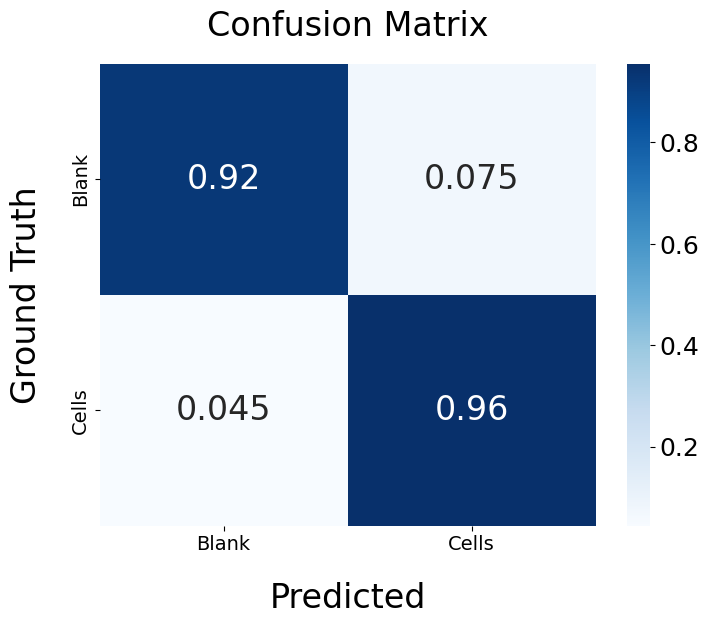

In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = model.cuda()

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["Blank", "Cells"], 
                                          yticklabels=["Blank", "Cells"], annot_kws={'size': 24})
plt.xlabel("Predicted", fontsize=24, labelpad=20)
plt.ylabel("Ground Truth", fontsize=24, labelpad=20)
plt.title("Confusion Matrix", fontsize=24, pad=20)

# Adjust colorbar font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=18)  # Set colorbar tick font size

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/figure3/confusion_matrix.svg', format='svg', transparent=True)
plt.show()